In [ ]:
 !pip install -q kaggle
 from google.colab import files
 files.upload()

MessageError: ignored

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle competitions download -c modia-phyml-22

  0% 0.00/4.43M [00:00<?, ?B/s]
100% 4.43M/4.43M [00:00<00:00, 58.8MB/s]


In [ ]:
! mkdir nouveau
! unzip modia-phyml-22.zip -d train 

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: train/nouveau/atoms/train/id_2594.xyz  
  inflating: train/nouveau/atoms/train/id_2595.xyz  
  inflating: train/nouveau/atoms/train/id_2596.xyz  
  inflating: train/nouveau/atoms/train/id_2597.xyz  
  inflating: train/nouveau/atoms/train/id_2598.xyz  
  inflating: train/nouveau/atoms/train/id_2599.xyz  
  inflating: train/nouveau/atoms/train/id_26.xyz  
  inflating: train/nouveau/atoms/train/id_260.xyz  
  inflating: train/nouveau/atoms/train/id_2600.xyz  
  inflating: train/nouveau/atoms/train/id_2601.xyz  
  inflating: train/nouveau/atoms/train/id_2602.xyz  
  inflating: train/nouveau/atoms/train/id_2603.xyz  
  inflating: train/nouveau/atoms/train/id_2604.xyz  
  inflating: train/nouveau/atoms/train/id_2605.xyz  
  inflating: train/nouveau/atoms/train/id_2606.xyz  
  inflating: train/nouveau/atoms/train/id_2607.xyz  
  inflating: train/nouveau/atoms/train/id_2608.xyz  
  inflating: train/nouve

In [ ]:
!pip install ase
!pip install dscribe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from ase import io, Atoms
import ase.data
import numpy as np 
import os 
import pandas as pd
import math 
import csv
from dscribe.descriptors import CoulombMatrix, MBTR
import matplotlib.pyplot as plt 
import random

# Preprocessing of atom structures

### getting the xyz data and create dataframe

In [ ]:
def get_number_atoms(chemical_symbols):
    n_c = chemical_symbols.count("C")
    n_n = chemical_symbols.count("N")
    n_h = chemical_symbols.count("H")
    n_o = chemical_symbols.count("O")
    n_s = chemical_symbols.count("S")
    n_cl = chemical_symbols.count("Cl")
    return [n_c, n_n, n_h, n_o, n_s, n_cl]


In [ ]:
def generate_train_aug():
    directory = 'train/nouveau/atoms/train'

    nb_val = 1
    nb_max_val = 1000
    mbtr = MBTR(
      species=["C", "N", "H", "O", "S","Cl"],
      # k1={
      #     "geometry": {"function": "atomic_number"},
      #     "grid": {"min": 0, "max": 8, "n": 100, "sigma": 0.1},
      # },
      k2={
          "geometry": {"function": "inverse_distance"},
          "grid": {"min": 0, "max": 1, "n": 100, "sigma": 0.1},
          "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
      },
      # k3={
      #     "geometry": {"function": "cosine"},
      #     "grid": {"min": -1, "max": 1, "n": 100, "sigma": 0.1},
      #     "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
      # },
      periodic=False,
      flatten=False,
      sparse=False,
      normalization="l2_each",
    )

    max_atomes_per_mol = 23
    Cmat_init = CoulombMatrix(max_atomes_per_mol, permutation='sorted_l2', flatten=False)
    Cmat_aug_init = CoulombMatrix(max_atomes_per_mol, permutation='random', sigma=0.5, flatten=False)

    data = pd.DataFrame(columns=['index', 'Coulomb_matrix', "masse", 'num_atoms', 'vectorized_mat', 'mbtr', 'Energy'])
    data_val = pd.DataFrame(columns=['index', 'Coulomb_matrix', "masse", 'num_atoms', 'vectorized_mat', 'mbtr', 'Energy'])
    data_aug = pd.DataFrame(columns=['index', 'Coulomb_matrix', "masse", 'num_atoms', 'vectorized_mat', 'mbtr', 'Energy'])


    molecules = []
    indexes = []
    max_atomes_per_mol = 23

    csv_file = 'train/nouveau/energies/train.csv'
    file = open(csv_file)
    csvreader = csv.reader(file)
    header = next(csvreader)
    rows = []
    for row in csvreader:
        index, energy = int(row[0]), float(row[1])
        index_augment, energy_augment =  int(row[0]) + 15000, float(row[1])

        filename = "id_"+str(index)+".xyz"
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            mol = io.read(f)
            C_mat = Cmat_init.create(mol)
            manybody = mbtr.create(mol)["k2"]
            v_mat = np.array(C_mat)[np.triu_indices_from(np.array(C_mat))]
            C_mat_aug = Cmat_aug_init.create(mol)
            v_mat_aug = np.array(C_mat_aug)[np.triu_indices_from(np.array(C_mat_aug))]
            masse = np.sum(mol.get_masses())
            num_atoms = get_number_atoms(mol.get_chemical_symbols())

            # if random.random() <= 0.7 and nb_val <= nb_max_val:
            #   nb_val += 1
            #   data_val = data_val.append({'index' : index, 'Coulomb_matrix' :C_mat, 'masse' : masse, 'num_atoms' : num_atoms, 'vectorized_mat' : v_mat, 'mbtr' : manybody, 'Energy':energy}, ignore_index = True)
            # else : 
            data = data.append({'index' : index, 'Coulomb_matrix' :C_mat, 'masse' : masse, 'num_atoms' : num_atoms, 'vectorized_mat' : v_mat, 'mbtr' : manybody, 'Energy':energy}, ignore_index = True)
            data_aug = data_aug.append({'index' : index_augment, 'Coulomb_matrix' :C_mat_aug, 'masse' : masse, 'num_atoms' : num_atoms, 'vectorized_mat' : v_mat_aug, 'mbtr' : manybody, 'Energy':energy_augment}, ignore_index = True)
    
    data_val = data.sample(n=nb_max_val)
    # print(data_val.head())
    data_val = data_val.set_index('index')
    data_val.sort_index(ascending=False,inplace=True)
    print(data_val.head())

    data.drop(index=data_val.index,inplace=True)
    data_val.sort_index(inplace=True)
    # data_val = data_val.set_index('index')
    data_final = data.append(data_aug,ignore_index=False)
    # data = data.sort_index()

    return data_final, data_val

def generate_test():
    directory = 'train/nouveau/atoms/test'
    mbtr = MBTR(
      species=["C", "N", "H", "O", "S","Cl"],
      # k1={
      #     "geometry": {"function": "atomic_number"},
      #     "grid": {"min": 0, "max": 8, "n": 100, "sigma": 0.1},
      # },
      k2={
          "geometry": {"function": "inverse_distance"},
          "grid": {"min": 0, "max": 1, "n": 100, "sigma": 0.1},
          "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
      },
      # k3={
      #     "geometry": {"function": "cosine"},
      #     "grid": {"min": -1, "max": 1, "n": 100, "sigma": 0.1},
      #     "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
      # },
      periodic=False,
      flatten=False,
      sparse=False,
      normalization="l2_each",
    )
    data = pd.DataFrame(columns=['index', 'Coulomb_matrix', "masse", 'num_atoms', 'vectorized_mat'])
    molecules = []
    indexes = []
    max_atomes_per_mol = 23
    Cmat_init = CoulombMatrix(max_atomes_per_mol, permutation='sorted_l2', flatten=False)
    Cmat_aug_init = CoulombMatrix(max_atomes_per_mol, permutation='random', sigma=0.5, flatten=False)

    #coulomb matrix :
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            mol = io.read(f)
            index = int(filename.split('id_')[1].split('.xyz')[0])
            C_mat = Cmat_init.create(mol)
            manybody = mbtr.create(mol)["k2"]
            v_mat = np.array(C_mat)[np.triu_indices_from(np.array(C_mat))]
            C_mat_aug = Cmat_aug_init.create(mol)
            masse = np.sum(mol.get_masses())
            num_atoms = get_number_atoms(mol.get_chemical_symbols())
        # if i == 0 :
        #   n_elements = len(mbtr.species)
        #   imap = mbtr.index_to_atomic_number
        #   x = np.linspace(0, 0.5, 100)
        #   smap = {index: ase.data.chemical_symbols[number] for index, number in imap.items()}

        #   # Plot k=2
        #   fig, ax = plt.subplots()
        #   for l in range(n_elements):
        #       for j in range(n_elements):
        #           if j >= l:
        #               # print(manybody['k2'].shape)
        #               plt.plot(x, manybody["k2"][l, j, :], label="{}-{}".format(smap[l], smap[j]))
        #               # plt.plot(x, manybody["k1"][l, :], label="{}".format(smap[l], smap[j]))
        #   ax.set_xlabel("Inverse distance (1/angstrom)")
        #   # plt.legend()
        #   plt.show()

        data = data.append({'index' : index, 'Coulomb_matrix' :C_mat, 'masse' : masse, 'num_atoms' : num_atoms, 'vectorized_mat' : v_mat, 'mbtr':manybody}, ignore_index = True)

    data = data.set_index('index')
    data = data.sort_index()

    return data

In [ ]:
df_train, df_val = generate_train_aug()
df_test = generate_test()

                                          Coulomb_matrix   masse  \
index                                                              
6762   [[11.44265903862993, 14.336508839097121, 9.817...  97.161   
6761   [[53.3587073998281, 28.58218542021524, 28.6393...  97.161   
6760   [[15.494505915654084, 33.87303074024085, 11.82...  90.122   
6752   [[23.063178270314925, 73.51669471981023, 15.96...  90.122   
6748   [[17.33961911621171, 53.3587073998281, 16.8150...  75.111   

                 num_atoms                                     vectorized_mat  \
index                                                                           
6762   [6, 1, 11, 0, 0, 0]  [11.44265903862993, 14.336508839097121, 9.8179...   
6761   [6, 1, 11, 0, 0, 0]  [53.3587073998281, 28.58218542021524, 28.63930...   
6760   [4, 0, 10, 2, 0, 0]  [15.494505915654084, 33.87303074024085, 11.824...   
6752   [4, 0, 10, 2, 0, 0]  [23.063178270314925, 73.51669471981023, 15.962...   
6748    [3, 1, 9, 1, 0, 0]  [17.33961

In [ ]:
print(df_train.shape)
print(df_val.shape)
print(X_test.shape)

(12540, 7)
(1000, 6)
(1689, 5)


In [ ]:
X_test.head()

,Coulomb_matrix,masse,num_atoms,vectorized_mat,mbtr
index,,,,,
6774,"[[28.540778118073003, 23.85920607442147, 15.39...",97.161,"[6, 1, 11, 0, 0, 0]","[28.540778118073003, 23.85920607442147, 15.397...","[[[0.004805941, 0.005903444, 0.007188154, 0.00..."
6775,"[[13.288283100002275, 10.979817427249777, 9.27...",97.161,"[6, 1, 11, 0, 0, 0]","[13.288283100002275, 10.979817427249777, 9.278...","[[[0.004225775, 0.005283906, 0.006547995, 0.00..."
6776,"[[10.73711337776919, 28.628572024768772, 13.42...",100.165,"[5, 2, 12, 0, 0, 0]","[10.73711337776919, 28.628572024768772, 13.424...","[[[0.0041045113, 0.0051556756, 0.0064194696, 0..."
6777,"[[14.318233947893248, 9.556128522215731, 26.88...",94.157,"[7, 0, 10, 0, 0, 0]","[14.318233947893248, 9.556128522215731, 26.888...","[[[0.0046612252, 0.0056893015, 0.0068859626, 0..."
6778,"[[10.887890497499981, 13.519162050733867, 23.7...",99.177,"[6, 1, 13, 0, 0, 0]","[10.887890497499981, 13.519162050733867, 23.76...","[[[0.00452118, 0.005628491, 0.006947776, 0.008..."
...,...,...,...,...,...
8458,"[[11.666824914690942, 13.433985147857971, 8.09...",95.145,"[6, 1, 9, 0, 0, 0]","[11.666824914690942, 13.433985147857971, 8.094...","[[[0.002871493, 0.0035437683, 0.0043423767, 0...."
8459,"[[14.254024803570521, 10.71149391320848, 26.93...",96.173,"[7, 0, 12, 0, 0, 0]","[14.254024803570521, 10.71149391320848, 26.938...","[[[0.0041083447, 0.0051107844, 0.006301762, 0...."
8460,"[[19.739966056900162, 23.424594547446183, 14.0...",74.123,"[4, 0, 10, 1, 0, 0]","[19.739966056900162, 23.424594547446183, 14.09...","[[[0.0026719093, 0.0033548279, 0.004177426, 0...."


In [ ]:
def plot_training_analysis():
  rmse = history.history['root_mean_squared_error']
  val_rmse = history.history['val_root_mean_squared_error']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(rmse))

  plt.plot(epochs, rmse, 'b', linestyle="--",label='Training rmse')
  plt.plot(epochs, val_rmse, 'g', label='Validation rmse')
  plt.title('Training and validation rmse')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

### Analysis of atom caracteristics

In [ ]:
import matplotlib.pyplot as plt

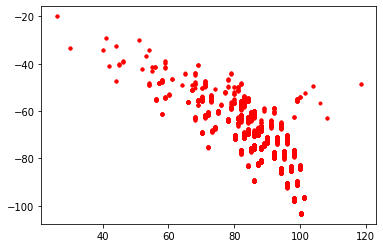

In [ ]:
plt.plot(df_train["masse"].values,df_train["Energy"].values, '.r')

# Prediction model 

### XG-boost

In [ ]:
import xgboost as xgb
 
 from sklearn.metrics import mean_squared_error
regressor = xgb.XGBRegressor(
    objective="reg:linear", 
    booster= 'gbtree',
    n_estimators=10000,
    reg_lambda=1,
    learning_rate=0.005,
    gamma=0,
    max_depth=6,
    min_child_weight=1,
    supsample=0.5,
    colsample_bytree=0.5)
regressor.fit(X_train, y_train)#, eval_set=[(X_validation, y_validation)])

In [ ]:
# y_pred = regressor.predict(X_validation)
# np.sqrt(mean_squared_error(y_pred, y_validation))
# y_hat_list = regressor.predict(X_test)

### Linear regression on number of atoms per molecule

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.linear_model import LinearRegression

#créer un objet reg lin
modeleReg=LinearRegression()

#créer y et X
masse_train = df_train["masse"].values
y_train=df_train["Energy"].values
X_train=df_train["num_atoms"].values

masse_validation=df_val["masse"].values
y_validation=df_val["Energy"].values
X_validation=df_val["num_atoms"].values
X_train,X_train.shape,y_train,y_train.shape

(array([list([5, 2, 12, 0, 0, 0]), list([6, 1, 13, 0, 0, 0]),
        list([6, 1, 11, 0, 0, 0]), ..., list([7, 0, 10, 0, 0, 0]),
        list([6, 1, 11, 0, 0, 0]), list([4, 1, 11, 0, 0, 0])], dtype=object),
 (12540,),
 array([-83.49055516, -90.17396994, -84.34541927, ..., -84.19615837,
        -83.86043227, -68.26001656]),
 (12540,))

In [ ]:
data_size= len(X_train)

X_train_bis=X_train.copy()
X_train = np.zeros((data_size,7))
for i in range(data_size):
  for j in range(6):
    X_train[i,j]=int(X_train_bis[i][j])
  X_train[i,6]=float(masse_train[i])
print(X_train),print(X_train.shape)


[[  5.      2.     12.    ...   0.      0.    100.165]
 [  6.      1.     13.    ...   0.      0.     99.177]
 [  6.      1.     11.    ...   0.      0.     97.161]
 ...
 [  7.      0.     10.    ...   0.      0.     94.157]
 [  6.      1.     11.    ...   0.      0.     97.161]
 [  4.      1.     11.    ...   0.      0.     73.139]]
(12540, 7)


(None, None)

In [ ]:
validation_size= len(X_validation)

X_validation_bis=X_validation.copy()
X_validation = np.zeros((validation_size,7))
for i in range(validation_size):
  for j in range(6):
    X_validation[i,j]=int(X_validation_bis[i][j])
  X_validation[i,6]=float(masse_validation[i])
print(X_validation),print(X_validation.shape)


[[ 4.     0.    10.    ...  0.     0.    90.122]
 [ 4.     0.     8.    ...  0.     0.    88.106]
 [ 7.     0.    14.    ...  0.     0.    98.189]
 ...
 [ 4.     0.    10.    ...  0.     0.    90.122]
 [ 6.     1.    11.    ...  0.     0.    97.161]
 [ 6.     1.    11.    ...  0.     0.    97.161]]
(1000, 7)


(None, None)

In [ ]:
from sklearn.metrics import mean_squared_error
modellin = LinearRegression().fit(X_train,y_train)
ychap=modellin.predict(X_validation)
print(modellin.score(X_validation,y_validation))
mean_squared_error(ychap, y_validation)

0.997841765869023


0.30756808389374124

In [ ]:
X_test=df_test["num_atoms"].values
masse_test=df_test["masse"].values
test_size= len(X_test)

X_test_bis=X_test.copy()
X_test = np.zeros((test_size,7))
for i in range(test_size):
  for j in range(6):
    X_test[i,j]=int(X_test_bis[i][j])
  X_test[i,6]=float(masse_test[i])
print(X_test),print(X_test.shape)
y_hat_list=modellin.predict(X_test)
y_hat_list

[[  6.      1.     11.    ...   0.      0.     97.161]
 [  6.      1.     11.    ...   0.      0.     97.161]
 [  5.      2.     12.    ...   0.      0.    100.165]
 ...
 [  4.      0.     10.    ...   0.      0.     74.123]
 [  7.      0.     10.    ...   0.      0.     94.157]
 [  5.      2.     10.    ...   0.      0.     98.149]]
(1689, 7)


array([-84.21412125, -84.21412125, -83.68155137, ..., -67.02140465,
       -84.74668732, -77.57681885])

### Kernel ridge regression

In [ ]:
kr = KernelRidge(kernel='rbf', gamma=0.1, alpha = 1)
X = np.squeeze([list(a) for a in df_train[['vectorized_mat']].values], 1)
print(np.array(X).shape)
y = df_train_split[['Energy']].values
X_val = np.squeeze([list(a) for a in df_validation[['vectorized_mat']].values], 1)
data_val = (X_val, df_validation[['Energy']].values)
kr.fit(X, y) 

NameError: ignored

In [ ]:
y_val = df_validation[['Energy']].values
np.sqrt(mean_squared_error(kr.predict(X_val), y_val))

### Conv2D

In [ ]:
from tensorflow.python.client import device_lib
import tensorflow as tf
import keras

from tensorflow.keras import optimizers
from tensorflow.keras import Input, layers, models
from keras.layers.convolutional import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.layers import Dense, Flatten, Dropout
import pandas as pd
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
from keras import backend as K

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [ ]:
model = models.Sequential()
model.add(Conv2D(32, 3, activation='relu', padding='same', input_shape = (6, 6, 100)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, 3, activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense  
model.add(Dense(1024, activation='relu'))   # Couche dense, à 512 neurones
model.add(Dense(512, activation='relu'))   # Couche dense, à 512 neurones
model.add(Dense(1, activation = 'linear'))
model.summary()
model.compile(loss="MeanSquaredError",
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=[root_mean_squared_error])


In [ ]:
X = np.squeeze([list(a) for a in df_train[['mbtr']].values], 1)
print(np.array(X).shape)
y = df_train[['Energy']].values
X_val = np.squeeze([list(a) for a in df_val[['mbtr']].values], 1)
data_val = (X_val, df_val[['Energy']].values)
history = model.fit(X, y, validation_data = data_val, epochs=1500, batch_size = 32)

In [ ]:
predict_test = np.squeeze([list(a) for a in X_test[['mbtr']].values], 1)
y_hat_list = np.squeeze(model.predict(predict_test), 1)

In [ ]:
y_hat_list

### Conv1D

In [ ]:
input_shape = (282, 1)
input_tensor = Input(shape=(input_shape))
p=0.3

x = layers.Conv1D(32, 3, activation='relu', padding='same', strides=1)(input_tensor)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(64, 3, activation='relu', padding = 'same', strides=1)(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
output_tensor = layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(input_tensor, output_tensor)

model.compile(loss="MeanSquaredError",
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=[root_mean_squared_error])

In [ ]:
model.summary()

In [ ]:
# X1d = np.squeeze([list(a) for a in df_train[['vectorized_mat']].values], 1)
X1d = np.array([[*list(row['vectorized_mat']), *list(row['num_atoms'])] for index, row in df_train.iterrows()])
print(X1d)
print(X1d.shape)
# print(np.squeeze([list(a) for a in df_train_split[['vectorized_mat']].values], 1).shape)
y1d = df_train[['Energy']].values
# X1d_val = np.squeeze([list(a) for a in df_val[['vectorized_mat']].values], 1)
X1d_val = np.array([[*list(row['vectorized_mat']), *list(row['num_atoms'])] for index, row in df_val.iterrows()])
print(np.array(X1d_val).shape)
data_val = (X1d_val, df_val[['Energy']].values)
history = model.fit(X1d, y1d, validation_data = data_val, epochs=300)

In [ ]:
# X_test = np.squeeze([list(a) for a in X_test[['vectorized_mat']].values], 1)
predict_test = np.array([[*list(row['vectorized_mat']), *list(row['num_atoms'])] for index, row in X_test.iterrows()])
# print(predict_test.shape)
# y_hat_list = np.squeeze(model.predict(X_test), 1)
y_hat_list = model.predict(predict_test)
y_hat_list

# Double network

In [ ]:
def create_2DCNN(input_tensor) : 
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(input_tensor)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(32, 3, activation='relu', padding = 'same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    return x

def create_1DCNN(input_tensor) : 
    x = layers.Conv1D(32, 3, activation='relu', padding='same', strides=1)(input_tensor)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 3, activation='relu', padding = 'same', strides=1)(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(128, 3, activation='relu', padding = 'same', strides=1)(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Flatten()(x)
    return x

in1 = Input(shape=(6, 6, 100))
in2 = Input(shape=(276, 1))
x1 = create_2DCNN(in1)
x2 = create_1DCNN(in2)
x = layers.Concatenate()([x1, x2])

x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
output_tensor = layers.Dense(1, activation='linear')(x)

model = tf.keras.Model(inputs=[in1, in2], outputs=[output_tensor])

model.compile(loss="MeanSquaredError",
              optimizer=optimizers.SGD(learning_rate=0.00005, momentum=0.5),
              metrics=[keras.metrics.RootMeanSquaredError()])

X2D = np.squeeze([list(a) for a in df_train[['mbtr']].values], 1)

X1D = np.squeeze([list(a) for a in df_train[['vectorized_mat']].values], 1)
print(X1D.shape)
y = df_train[['Energy']].values

X2D_val = np.squeeze([list(a) for a in df_val[['mbtr']].values], 1)
X1D_val = np.squeeze([list(a) for a in df_val[['vectorized_mat']].values], 1)
data_val = ([X2D_val, X1D_val], df_val[['Energy']].values)


history = model.fit([X2D, X1D], y, validation_data = data_val, epochs = 1000)
plot_training_analysis()

In [ ]:
# X_test = np.squeeze([list(a) for a in X_test[['vectorized_mat']].values], 1)
X2D_test = np.squeeze([list(a) for a in X_test[['mbtr']].values], 1)
# X1D_test = np.array([[*list(row['vectorized_mat']), *list(row['num_atoms'])] for index, row in X_test.iterrows()])
X1D_test = np.squeeze([list(a) for a in X_test[['vectorized_mat']].values], 1)

predict_test = [X2D_test, X1D_test]
# print(predict_test.shape)
# y_hat_list = np.squeeze(model.predict(X_test), 1)
y_hat_list = model.predict(predict_test)
y_hat_list.shape

In [ ]:
y_hat_list

In [ ]:
import re
from google.colab import files
test_directory = 'train/nouveau/atoms/test'
TEST_ID = [int(re.sub('\D', '', file)) for file in sorted(os.listdir(test_directory), key=lambda f: int(re.sub('\D', '', f)))]
# y_hat_list = [a.cpu() for a in y_hat_list]
y_predict = np.squeeze(y_hat_list,1)
print(np.array(TEST_ID).shape, np.array(y_predict).shape)
df = pd.DataFrame({'id' : TEST_ID, 'predicted' : y_predict})
df.head()
df.to_csv('prediction.csv', index=False)
files.download('prediction.csv')